#  &#x1F4D1; **作业 8: - 异常检测**

如果有任何问题，请联系[mlta-2022spring-ta@googlegroups.com](mlta-2022spring-ta@googlegroups.com)

Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw8)

# **加载包**

In [1]:
!pip install -q qqdm
!pip install netron

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.6 MB/s eta 0:00:0000:01


In [3]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
from tqdm import tqdm
import pandas as pd
import os

In [4]:
# 设置全局的随机种子
def all_seed(seed = 6666):
    """
    设置随机种子
    """
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed) 
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed) 
    # python 全局
    os.environ['PYTHONHASHSEED'] = str(seed) 
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')
   

In [5]:
all_seed(48763)

Set env random_seed = 48763


# **加载数据**
直接在kaggle中添加`ml2022spring-hw8`的数据

In [6]:
!ls ../input/ml2022spring-hw8/data

testingset.npy	trainingset.npy


In [7]:
root_path = '../input/ml2022spring-hw8/data'
train = np.load(f'{root_path}/trainingset.npy', allow_pickle=True)
test = np.load(f'{root_path}/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## 简单查看样本

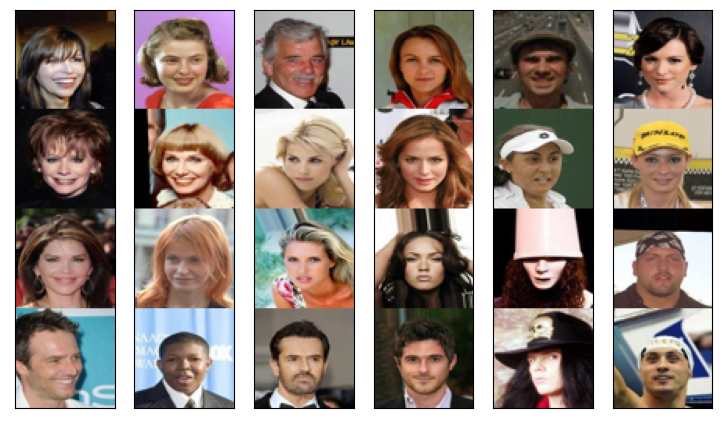

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 6, figsize=(6*1.5, 4*1.5))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axes]
axes[0].imshow(train[:4,...].reshape(-1, 64, 3))
axes[1].imshow(train[4:8,...].reshape(-1, 64, 3))
axes[2].imshow(train[8:12,...].reshape(-1, 64, 3))
axes[3].imshow(train[12:16,...].reshape(-1, 64, 3))
axes[4].imshow(test[:4,...].reshape(-1, 64, 3))
axes[5].imshow(test[4:8,...].reshape(-1, 64, 3))
plt.show()

# 自编码`Autoencoder`
##  &#x2728; 多种模型与损失

模型： 
- fcn_autoencoder: `encoder -> decoder`
- conv_autoencoder: `encoder -> decoder`
- VAE: `encoder-> Mean, LogVar -> Mean + eps * Std -> decoder`

损失：
- loss_vae： `mse + KLD` (反向KL)

$loss = mse + \sum{exp(\sigma) - (1+\sigma) + m^2} $

In [9]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(), 
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(), 
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),        
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),         
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    """
    产生和训练集中一样的图像
    """
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: 生成的图片
    x: 原来的图片
    mu: encoder中输出的mean
    logvar: encoder中输出的logVar
    """
    mse = criterion(recon_x, x)
    # 计算KL离散度 
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

## 模型可视化

In [10]:
import netron
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
d = torch.rand(1, 3, 64, 64).to(device)
m = VAE().to(device)
o = m(d)

onnx_path = "VAE.onnx"
torch.onnx.export(m, d, onnx_path)
 
# netron.start(onnx_path)
# netron.stop()

![HW08_model.png](./pic/HW08_model.png)

# Dataset

用于获取和处理数据的`DataSet`。这里的变换函数将图像的像素从[0, 255]归一化为[-1.01.0]。

In [11]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        # 进行归一化
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.tensors)

# **模型训练**

## 超参设置

In [12]:
# 训练参数
num_epochs = 5
batch_size = 2000
learning_rate = 1e-3

# 构建dataLoader
train_dataset = CustomTensorDataset(torch.from_numpy(train))
# 构建采样方法： 默认是不放回的抽样
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size) # 基本等价于 shuffle = True
# train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
# 模型
model_type = 'vae'
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE()}
model = model_classes[model_type].cuda()  if torch.cuda.is_available() else model_classes[model_type]

# 损失函数 与 优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##  &#x1F4CC; 开始训练！

In [13]:
best_loss = np.inf
model.train()

# qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in range(num_epochs):
    tq_train = tqdm(train_dataloader, leave=True)
    tq_train.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
    tot_loss = list()
    for data in tq_train:
        # ===================载入数据=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)

        # ===================前向传播=====================
        # decode, mu, logvar
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)
        
        tq_train.set_postfix({f'{model_type}_loss': loss.detach().item()})
        tot_loss.append(loss.item())
        # ===================反向传播====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================保存最佳模型====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
#     qqdm_train.set_infos({
#         'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
#         'loss': f'{mean_loss:.4f}',
#     })
    # ===================保存最后一个模型========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

Epoch [5/5]: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it, vae_loss=0.344]


# **模型推理**
加载模型并生成其异常分数预测

## 测试集初始化
- 构建测试集的dataloader
- 加载训练好的model
- 输出预测结果到 `prediction file`

In [14]:
eval_batch_size = 200

# 构建测试集数据
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# 加载模型
checkpoint_path = f'last_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

# 预测结果文件
out_file = 'submission.csv'

In [15]:
anomality = list()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)
        output = model(img)
        if model_type in ['vae']:
            output = output[0]
        if model_type in ['fcn']:
            loss = eval_loss(output, img).sum(-1)
        else:
            loss = eval_loss(output, img).sum([1, 2, 3])
        anomality.append(loss)

anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')

In [16]:
!head -n 10 submission.csv

ID,score
0,48.508358
1,57.371883
2,93.350586
3,76.73993
4,62.999203
5,52.656208
6,82.5256
7,65.29664
8,83.43319
